In [1]:
import pandas as pd
import numpy as np
import re
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import random
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==================== PREPROCESSING FUNCTIONS ====================
print("\n" + "="*80)
print("DEFINING PREPROCESSING FUNCTIONS")
print("="*80)

def clean_text(text):
    """
    Preprocessing sederhana: hanya menghilangkan URL, mention, hashtag, email, 
    tanda baca (titik, koma), dan emote
    """
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Hapus mention (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Hapus hashtag (#hashtag)
    text = re.sub(r'#\w+', '', text)
    
    # Hapus email
    text = re.sub(r'\S+@\S+', '', text)
    
    # Hapus tanda baca (titik, koma, dll) dan karakter khusus
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Hapus karakter berulang lebih dari 2 kali (contoh: 'bagusssss' -> 'bagus')
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    
    # Hapus whitespace berlebih
    text = re.sub(r'\s+', ' ', text)
    
    # Strip whitespace di awal dan akhir
    text = text.strip()
    
    # Lowercase
    text = text.lower()
    
    return text

print("Preprocessing functions defined!")

# ==================== DATA AUGMENTATION FUNCTIONS ====================
print("\n" + "="*80)
print("DEFINING DATA AUGMENTATION FUNCTIONS")
print("="*80)

import random

# Kamus sinonim lebih lengkap
AUG_SYNONYM = {
    "bagus": ["baik", "mantap", "oke", "keren"],
    "jelek": ["buruk", "parah", "tidak bagus", "kurang"],
    "error": ["bug", "masalah", "kendala"],
    "crash": ["force close", "tutup sendiri"],
    "lemot": ["lambat", "slow", "lelet"],
    "lambat": ["lemot", "slow"],
    "cepat": ["kilat", "langsung", "gesit"],
    "loading": ["memuat", "proses"],
    "fitur": ["feature", "menu", "fungsi"],
    "update": ["pembaruan", "upgrade"],
    "login": ["masuk", "sign in"],
    "logout": ["keluar", "sign out"],
    "akun": ["account", "profil"],
    "otp": ["kode verifikasi", "kode keamanan", "verification code"],
    "kode": ["OTP", "security code"],
    "layanan": ["service", "pelayanan"]
}

def synonym_replacement(text, p=0.25):
    """Augmentasi dengan probabilitas penggantian 25%"""
    words = text.split()
    new_words = []

    for w in words:
        if w.lower() in AUG_SYNONYM and random.random() < p:  # 25% probability
            synonym = random.choice(AUG_SYNONYM[w.lower()])
            new_words.append(synonym)
        else:
            new_words.append(w)

    return " ".join(new_words)


def augment_text(text, num_aug=1):
    """Augmentasi text berbasis synonym replacement"""
    augmented_texts = []
    for _ in range(num_aug):
        augmented_texts.append(synonym_replacement(text, p=0.25))
    return augmented_texts


print("Augmentasi Synonym Replacement with Probability 0.25 ✓")


Using device: cpu

DEFINING PREPROCESSING FUNCTIONS
Preprocessing functions defined!

DEFINING DATA AUGMENTATION FUNCTIONS
Augmentasi Synonym Replacement with Probability 0.25 ✓


In [2]:
# ==================== 1. LOADING & CLEANING DATA ====================
print("\n" + "="*80)
print("STEP 1: LOADING & PREPROCESSING DATA")
print("="*80)

# Load dataset
df = pd.read_csv('data_prelabeled_full.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")

# Cek nilai unik di kolom polaritas
print("\nNilai unik di kolom 'polaritas':")
print(df['polaritas'].unique())
print(f"\nJumlah nilai NaN di 'polaritas': {df['polaritas'].isna().sum()}")

# Hapus baris dengan NaN di kolom penting
print(f"\nUkuran dataset sebelum cleaning: {len(df)}")
df = df.dropna(subset=['aspect', 'context', 'polaritas'])
print(f"Ukuran dataset setelah cleaning: {len(df)}")

# Contoh sebelum preprocessing
print("\n" + "-"*80)
print("CONTOH TEKS SEBELUM PREPROCESSING:")
print("-"*80)
sample_idx = 0
print(f"Aspect: {df.iloc[sample_idx]['aspect']}")
print(f"Context: {df.iloc[sample_idx]['context']}")

# Terapkan preprocessing pada kolom aspect dan context
print("\n" + "-"*80)
print("APPLYING PREPROCESSING PIPELINE...")
print("-"*80)

df['aspect_clean'] = df['aspect'].apply(clean_text)
df['context_clean'] = df['context'].apply(clean_text)

# Contoh setelah preprocessing
print("\nCONTOH TEKS SETELAH PREPROCESSING:")
print("-"*80)
print(f"Aspect Clean: {df.iloc[sample_idx]['aspect_clean']}")
print(f"Context Clean: {df.iloc[sample_idx]['context_clean']}")

# Normalize polaritas (lowercase dan strip whitespace)
df['polaritas'] = df['polaritas'].str.lower().str.strip()

# Mapping polaritas ke label numerik
label_map = {
    'positif': 2,
    'positive': 2,
    'netral': 1,
    'neutral': 1,
    'negatif': 0,
    'negative': 0
}

# Inverse mapping untuk interpretasi hasil
inv_label_map = {0: 'negatif', 1: 'netral', 2: 'positif'}

df['label'] = df['polaritas'].map(label_map)

# Cek apakah masih ada NaN setelah mapping
print(f"\nJumlah NaN setelah mapping: {df['label'].isna().sum()}")
if df['label'].isna().sum() > 0:
    print("\nBaris dengan label NaN (polaritas tidak dikenali):")
    print(df[df['label'].isna()][['polaritas']].head(10))
    print("\nMenghapus baris dengan label NaN...")
    df = df.dropna(subset=['label'])
    print(f"Ukuran dataset final: {len(df)}")

# Gabungkan aspect dan context yang sudah di-preprocessing untuk input
df['text'] = df['aspect_clean'] + " " + df['context_clean']

# Hapus baris dengan text kosong setelah preprocessing
df = df[df['text'].str.strip() != '']
print(f"\nUkuran dataset setelah menghapus text kosong: {len(df)}")

print(f"\nPolaritas distribution setelah preprocessing:")
print(df['polaritas'].value_counts())
print(f"\nLabel distribution:")
print(df['label'].value_counts())


STEP 1: LOADING & PREPROCESSING DATA
Dataset shape: (2924, 5)

Column names: ['rating', 'original', 'aspect', 'context', 'polaritas']

Nilai unik di kolom 'polaritas':
['Negatif' 'Netral' 'Positif']

Jumlah nilai NaN di 'polaritas': 0

Ukuran dataset sebelum cleaning: 2924
Ukuran dataset setelah cleaning: 2924

--------------------------------------------------------------------------------
CONTOH TEKS SEBELUM PREPROCESSING:
--------------------------------------------------------------------------------
Aspect: Aplikasi
Context: saat di lapangan tidak seindah saat di aplikasi terimakasih

--------------------------------------------------------------------------------
APPLYING PREPROCESSING PIPELINE...
--------------------------------------------------------------------------------

CONTOH TEKS SETELAH PREPROCESSING:
--------------------------------------------------------------------------------
Aspect Clean: aplikasi
Context Clean: saat di lapangan tidak seindah saat di aplikasi te

In [3]:
print("\n" + "="*80)
print("STATISTIK POLARITAS PER ASPEK")
print("="*80)

aspek_list = ["aplikasi", "kemudahan", "pembayaran"]

for aspek in aspek_list:
    print(f"\n>>> Aspek: {aspek.upper()}")
    aspek_df = df[df['aspect_clean'].str.contains(aspek, na=False)]
    
    if len(aspek_df) == 0:
        print("Tidak ada data.")
        continue

    print(aspek_df['label'].map(inv_label_map).value_counts())


STATISTIK POLARITAS PER ASPEK

>>> Aspek: APLIKASI
label
negatif    1272
positif     157
netral       35
Name: count, dtype: int64

>>> Aspek: KEMUDAHAN
label
negatif    542
positif    117
netral      13
Name: count, dtype: int64

>>> Aspek: PEMBAYARAN
label
negatif    709
positif     58
netral      21
Name: count, dtype: int64


In [4]:
# ==================== 2. SPLIT DATA DULU (SEBELUM AUGMENTASI!) ====================
print("\n" + "="*80)
print("STEP 2: SPLIT DATA (TRAIN/VAL/TEST)")
print("="*80)

# Split train dan test terlebih dahulu
train_val_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42,
    stratify=df['label']
)

print(f"\nTrain+Val size: {len(train_val_df)}")
print(f"Test size: {len(test_df)}")

# Split training data menjadi train dan validation
train_df, val_df = train_test_split(
    train_val_df, 
    test_size=0.2, 
    random_state=42,
    stratify=train_val_df['label']
)

print(f"\nFinal train size (sebelum augmentasi): {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

print(f"\nTrain label distribution (sebelum augmentasi):")
print(train_df['label'].value_counts().sort_index())



STEP 2: SPLIT DATA (TRAIN/VAL/TEST)

Train+Val size: 2339
Test size: 585

Final train size (sebelum augmentasi): 1871
Validation size: 468
Test size: 585

Train label distribution (sebelum augmentasi):
label
0    1614
1      44
2     213
Name: count, dtype: int64


In [ ]:
# ==================== 3. DATA AUGMENTATION (HANYA PADA TRAINING SET!) ====================
print("\n" + "="*80)
print("STEP 3: DATA AUGMENTATION (TRAINING SET ONLY)")
print("="*80)

# Hitung jumlah sampel per kelas
label_counts = train_df['label'].value_counts().sort_index()
print("\nLabel distribution SEBELUM augmentasi (training set):")
for label, count in label_counts.items():
    print(f"  {inv_label_map[label]}: {count}")

# Ambil jumlah maksimum (negatif 2018)
max_count = label_counts[0]     # kelas negatif adalah mayoritas
target_samples = {
    0: label_counts[0],         # negatif tetap sama, tidak di-augment
    1: max_count,               # netral dinaikkan jadi 2018
    2: max_count                # positif dinaikkan jadi 2018
}

augmented_data = []

print("\n" + "-"*80)
print("AUGMENTING MINORITY CLASSES...")
print("-"*80)

for label in [1, 2]:  # Hanya augment netral & positif
    label_df = train_df[train_df['label'] == label]
    current_count = len(label_df)
    target_count = target_samples[label]

    if current_count < target_count:
        num_to_generate = target_count - current_count
        print(f"\nAugmenting {inv_label_map[label]}: {current_count} -> {target_count} (+{num_to_generate})")

        for _ in tqdm(range(num_to_generate), desc=f"Augmenting {inv_label_map[label]}"):
            sample = label_df.sample(1).iloc[0]
            augmented_text = augment_text(sample['text'], num_aug=1)[0]

            augmented_data.append({
                'aspect': sample['aspect'],
                'context': sample['context'],
                'aspect_clean': sample['aspect_clean'],
                'context_clean': sample['context_clean'],
                'text': augmented_text,
                'polaritas': sample['polaritas'],
                'label': sample['label']
            })

# Tambahkan ke train_df
if augmented_data:
    augmented_df = pd.DataFrame(augmented_data)
    train_df = pd.concat([train_df, augmented_df], ignore_index=True)

    print("\n" + "-"*80)
    print("Label distribution SETELAH augmentasi (training set):")
    print("-"*80)
    print(train_df['label'].value_counts().sort_index())

print("\n" + "="*80)
print("SUMMARY AFTER AUGMENTATION:")
print("="*80)
print(f"Final train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")
====


STEP 3: DATA AUGMENTATION (TRAINING SET ONLY)

Label distribution SEBELUM augmentasi (training set):
  negatif: 1614
  netral: 44
  positif: 213

--------------------------------------------------------------------------------
AUGMENTING MINORITY CLASSES...
--------------------------------------------------------------------------------

Augmenting netral: 44 -> 1614 (+1570)


Augmenting netral: 100%|██████████| 1570/1570 [00:00<00:00, 8949.76it/s]



Augmenting positif: 213 -> 1614 (+1401)


Augmenting positif: 100%|██████████| 1401/1401 [00:00<00:00, 8803.95it/s]


--------------------------------------------------------------------------------
Label distribution SETELAH augmentasi (training set):
--------------------------------------------------------------------------------
label
0    1614
1    1614
2    1614
Name: count, dtype: int64

SUMMARY AFTER AUGMENTATION:
Final train size: 4842
Validation size: 468
Test size: 585


In [6]:
# ==================== 4. LOAD INDOBERT MODEL & TOKENIZER ====================
print("\n" + "="*80)
print("STEP 4: LOADING INDOBERT MODEL & TOKENIZER")
print("="*80)

MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME).to(device)

print(f"Model and tokenizer loaded: {MODEL_NAME}")

# ==================== 5. EXTRACT EMBEDDINGS ====================
def get_bert_embeddings(texts, batch_size=16):
    """
    Extract BERT embeddings for a list of texts
    Returns: numpy array of shape (num_texts, hidden_size)
    """
    embeddings = []
    bert_model.eval()
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Extracting embeddings"):
            batch_texts = texts[i:i+batch_size]
            
            # Tokenize
            encoded = tokenizer(
                batch_texts,
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)
            
            # Get BERT output
            outputs = bert_model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            # Use [CLS] token embedding (first token)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeddings)
    
    return np.vstack(embeddings)

print("\n" + "="*80)
print("STEP 5: EXTRACTING EMBEDDINGS")
print("="*80)

# Extract embeddings for train, val, and test sets
print("\nExtracting train embeddings...")
X_train = get_bert_embeddings(train_df['text'].tolist())
y_train = train_df['label'].values

print("\nExtracting validation embeddings...")
X_val = get_bert_embeddings(val_df['text'].tolist())
y_val = val_df['label'].values

print("\nExtracting test embeddings...")
X_test = get_bert_embeddings(test_df['text'].tolist())
y_test = test_df['label'].values

print(f"\nEmbeddings shape:")
print(f"  Train: {X_train.shape}")
print(f"  Validation: {X_val.shape}")
print(f"  Test: {X_test.shape}")


STEP 4: LOADING INDOBERT MODEL & TOKENIZER
Model and tokenizer loaded: indobenchmark/indobert-base-p1

STEP 5: EXTRACTING EMBEDDINGS

Extracting train embeddings...


Extracting embeddings: 100%|██████████| 303/303 [06:12<00:00,  1.23s/it]



Extracting validation embeddings...


Extracting embeddings: 100%|██████████| 30/30 [00:36<00:00,  1.21s/it]



Extracting test embeddings...


Extracting embeddings: 100%|██████████| 37/37 [00:46<00:00,  1.27s/it]


Embeddings shape:
  Train: (4842, 768)
  Validation: (468, 768)
  Test: (585, 768)


In [7]:
# ==================== 6. TRAIN XGBOOST ====================
print("\n" + "="*80)
print("STEP 6: TRAINING XGBOOST CLASSIFIER")
print("="*80)

# XGBoost parameters
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'min_child_weight': 1,
    'random_state': 42,
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# Create XGBoost classifier
xgb_model = xgb.XGBClassifier(**params)

# Train with early stopping
print("\nTraining XGBoost model...")
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
)

print("\nTraining completed!")


STEP 6: TRAINING XGBOOST CLASSIFIER

Training XGBoost model...
[0]	validation_0-mlogloss:0.99355	validation_1-mlogloss:1.02498
[1]	validation_0-mlogloss:0.90800	validation_1-mlogloss:0.96300
[2]	validation_0-mlogloss:0.82941	validation_1-mlogloss:0.89946
[3]	validation_0-mlogloss:0.75687	validation_1-mlogloss:0.84978
[4]	validation_0-mlogloss:0.69933	validation_1-mlogloss:0.80918
[5]	validation_0-mlogloss:0.64178	validation_1-mlogloss:0.76320
[6]	validation_0-mlogloss:0.59262	validation_1-mlogloss:0.72535
[7]	validation_0-mlogloss:0.54730	validation_1-mlogloss:0.68920
[8]	validation_0-mlogloss:0.50612	validation_1-mlogloss:0.65927
[9]	validation_0-mlogloss:0.46908	validation_1-mlogloss:0.62661
[10]	validation_0-mlogloss:0.43681	validation_1-mlogloss:0.60050
[11]	validation_0-mlogloss:0.40420	validation_1-mlogloss:0.57779
[12]	validation_0-mlogloss:0.37824	validation_1-mlogloss:0.55941
[13]	validation_0-mlogloss:0.35221	validation_1-mlogloss:0.53944
[14]	validation_0-mlogloss:0.32785	v


STEP 7: EVALUATION

Validation Set:
Validation Accuracy: 0.9145

Test Set:
Test Accuracy: 0.9162

CLASSIFICATION REPORT (TEST SET)
              precision    recall  f1-score   support

     negatif       0.92      0.99      0.95       505
      netral       1.00      0.36      0.53        14
     positif       0.84      0.47      0.60        66

    accuracy                           0.92       585
   macro avg       0.92      0.61      0.69       585
weighted avg       0.91      0.92      0.90       585


Confusion Matrix:
[[500   0   5]
 [  8   5   1]
 [ 35   0  31]]


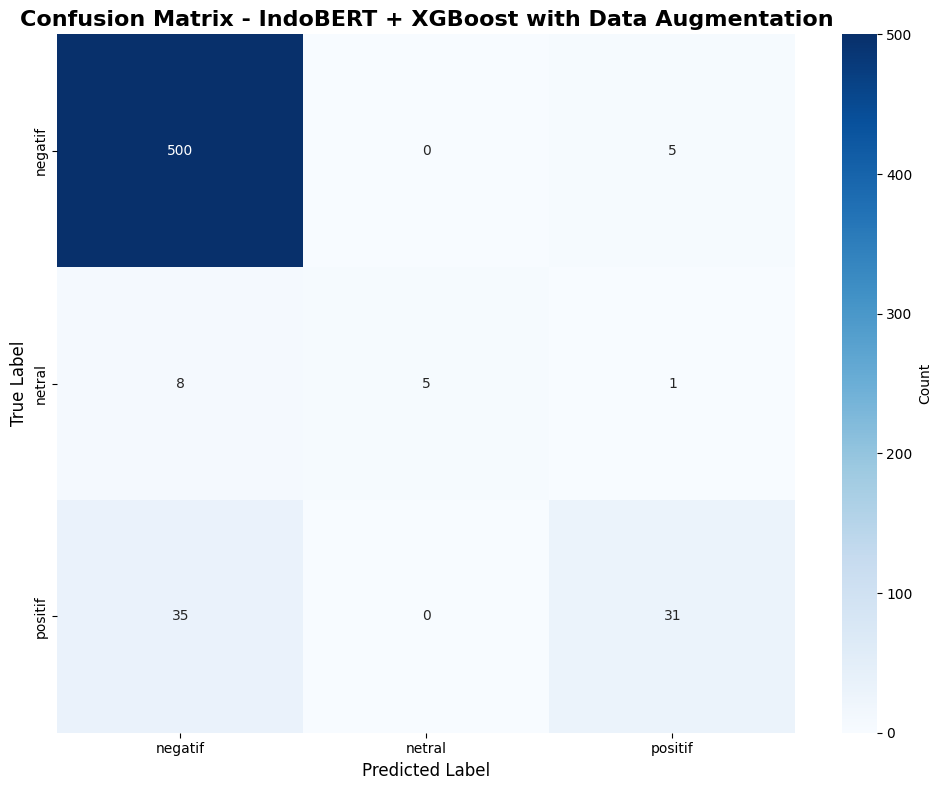


Confusion matrix saved as 'confusion_matrix_xgboost_augmented.png'


In [8]:
# ==================== 7. EVALUATION ====================
print("\n" + "="*80)
print("STEP 7: EVALUATION")
print("="*80)

# Validation evaluation
print("\nValidation Set:")
y_val_pred = xgb_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")

# Test evaluation
print("\nTest Set:")
y_test_pred = xgb_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification Report
target_names = ['negatif', 'netral', 'positif']
print("\n" + "="*80)
print("CLASSIFICATION REPORT (TEST SET)")
print("="*80)
print(classification_report(y_test, y_test_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - IndoBERT + XGBoost with Data Augmentation', 
          fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_xgboost_augmented.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved as 'confusion_matrix_xgboost_augmented.png'")


STEP 8: SAVING MODEL & PREDICTIONS

XGBoost model saved to 'xgboost_indobert_absa_augmented.json'
Test predictions saved to 'test_predictions_xgboost_augmented.csv'


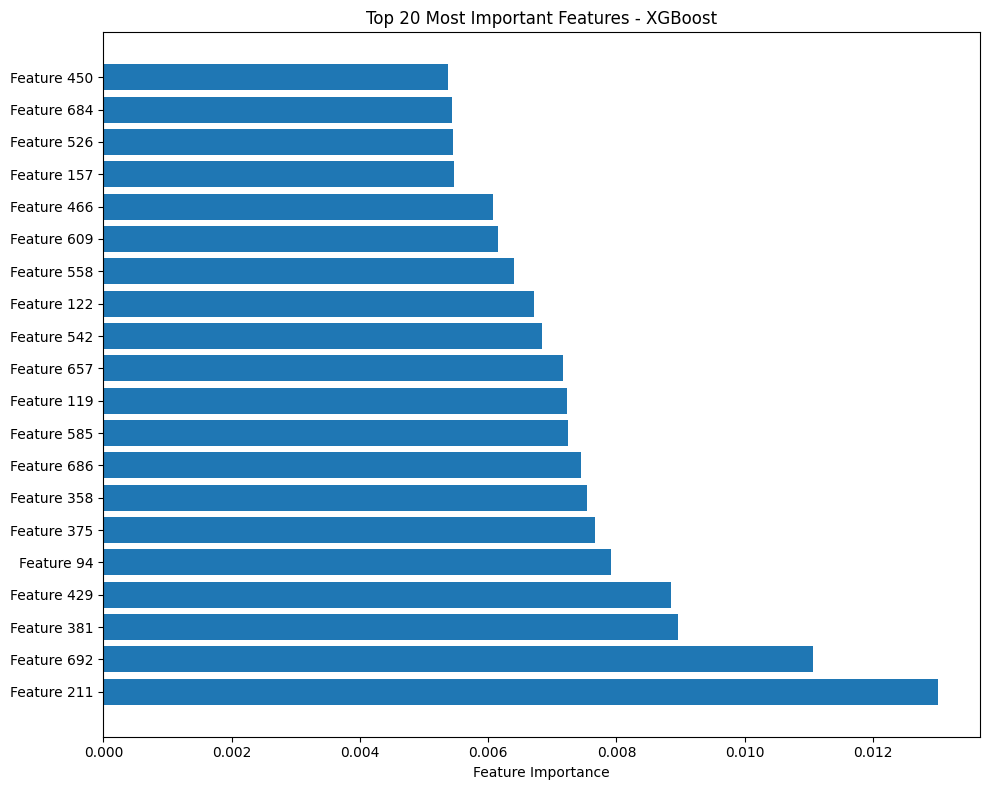

Feature importance plot saved as 'feature_importance_xgboost.png'

TRAINING & EVALUATION COMPLETED!

Files generated:
  1. xgboost_indobert_absa_augmented.json - XGBoost model
  2. confusion_matrix_xgboost_augmented.png - Confusion matrix
  3. test_predictions_xgboost_augmented.csv - Test set predictions
  4. feature_importance_xgboost.png - Feature importance plot


In [9]:
# ==================== 8. SAVE MODEL & PREDICTIONS ====================
print("\n" + "="*80)
print("STEP 8: SAVING MODEL & PREDICTIONS")
print("="*80)

# Save XGBoost model
xgb_model.save_model('xgboost_indobert_absa_augmented.json')
print("\nXGBoost model saved to 'xgboost_indobert_absa_augmented.json'")

# Save predictions
test_df_copy = test_df.copy()
test_df_copy['predicted_label'] = y_test_pred
test_df_copy['predicted_polaritas'] = test_df_copy['predicted_label'].map(inv_label_map)

test_df_copy.to_csv('test_predictions_xgboost_augmented.csv', index=False)
print("Test predictions saved to 'test_predictions_xgboost_augmented.csv'")

# Feature importance
feature_importance = xgb_model.feature_importances_
top_features_idx = np.argsort(feature_importance)[-20:][::-1]

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features_idx)), feature_importance[top_features_idx])
plt.yticks(range(len(top_features_idx)), 
           [f'Feature {idx}' for idx in top_features_idx])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features - XGBoost')
plt.tight_layout()
plt.savefig('feature_importance_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()

print("Feature importance plot saved as 'feature_importance_xgboost.png'")

print("\n" + "="*80)
print("TRAINING & EVALUATION COMPLETED!")
print("="*80)
print(f"\nFiles generated:")
print(f"  1. xgboost_indobert_absa_augmented.json - XGBoost model")
print(f"  2. confusion_matrix_xgboost_augmented.png - Confusion matrix")
print(f"  3. test_predictions_xgboost_augmented.csv - Test set predictions")
print(f"  4. feature_importance_xgboost.png - Feature importance plot")